In [1]:
import os
import pandas as pd
import soundfile
import fnmatch
import yaml
from wav2letter.datasets import Dataset, LSDataModule, DataModuleRF
from wav2letter.models import LitWav2Letter, Wav2LetterRF
import torchaudio
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.io import wavfile
import auditory_cortex.regression as Reg
import auditory_cortex.utils as utils
import numpy as np
import cupy as cp
import pickle
import time
from utils_jgm.tikz_pgf_helpers import tpl_save

import auditory_cortex.analysis.config as config
import auditory_cortex.helpers as helpers
import auditory_cortex.analysis.analysis as analysis

In [2]:
# paths to read checkpoints from and save corr results at...
models_dir = config.task_optimization_paths['model_checkpoints_dir']
saved_corr_results_dir = config.task_optimization_paths['saved_corr_results_dir']

### compute correlations and save to disk..

In [4]:


# read checkpoints from the directory..
checkpoints = []
for file_name in os.listdir(models_dir):
    if fnmatch.fnmatch(file_name, 'Wav2letter-epoch*.ckpt'):
        checkpoints.append(file_name)
checkpoints.sort()

# extract 'epochs' and 'loss' information from the checkpoint filenames...
pretrained_mdata = []
for checkpoint in checkpoints:
    # extract epoch number from latest checkpoint...
    upper_index = checkpoint.index('-val')
    lower_index = checkpoint.rfind('=', 0, upper_index) + 1
    epoch = int(checkpoint[lower_index:upper_index])

    # extract loss value from latest checkpoint...
    upper_index = checkpoint.index('.ckpt')
    lower_index = checkpoint.rfind('=', 0, upper_index) + 1
    loss = float(checkpoint[lower_index:upper_index])

    dictt = {'epochs': epoch,
             'loss': loss,
             'checkpoint': checkpoint
            }
    pretrained_mdata.append(dictt)

In [3]:
# running analysis...
i = 0
session = '200206'
bin_width = 20
delay = 20
epochs = pretrained_mdata[i]['epochs']
checkpoint = os.path.join(models_dir, pretrained_mdata[i]['checkpoint'])
corr_file_path = os.path.join(saved_corr_results_dir, f'w2l_epochs={epochs:02d}_session_{session}_corr.csv')

# compute correlations and save to disk...
reg_obj = helpers.get_regression_obj(session, checkpoint=checkpoint, load_features=True)
corr_results = reg_obj.cross_validated_regression(bin_width=bin_width, delay=delay, load_features=True, return_dict=True, numpy=False)
utils.write_to_disk(corr_results, corr_file_path)

#### Computing correlations for untrained model..

In [3]:
session = '200206'
bin_width = 20
delay = 0
epochs = 0 # pretrained_mdata[i]['epochs']
# checkpoint = os.path.join(models_dir, pretrained_mdata[i]['checkpoint'])
corr_file_path = os.path.join(saved_corr_results_dir, f'w2l_epochs={epochs:02d}_session_{session}_corr.csv')

# compute correlations and save to disk...
reg_obj = helpers.get_regression_obj(session, load_features=True, pretrained=False)
corr_results = reg_obj.cross_validated_regression(bin_width=bin_width, delay=delay, load_features=True, return_dict=True, numpy=False)
utils.write_to_disk(corr_results, corr_file_path)

Regression object...
Creating regression obj for: 'wav2letter_modified'
Loading ANN features at bin-width: 20
It takes 24.77 sec to load features...!
# of iterations requested: 10, 
# of lambda samples per iteration: 20
Itr: 1:
Itr: 2:
Itr: 3:
Itr: 4:
Itr: 5:
Itr: 6:
Itr: 7:
Itr: 8:
Itr: 9:
Itr: 10:
It takes (on avg.) 8.76 sec (all lmbdas). (time for 10-folds)
It takes (on avg.) 3.01 sec/mapping.
It takes (on avg.) 0.20 minutes/iteration...!
Data saved for model: 'wav2letter_modified', session: '200206',    bin-width: 20ms, delay: 0ms at file: '/depot/jgmakin/data/auditory_cortex/saved_results/task_optimization/w2l_epochs=00_session_200206_corr.csv'


,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,normalizer,N_sents
0,200206.0,0.0,0.0,20.0,0.0,0.106607,0.093577,0.0,499.0
1,200206.0,0.0,1.0,20.0,0.0,0.068458,0.045363,0.0,499.0
2,200206.0,0.0,2.0,20.0,0.0,0.06451,0.042679,0.0,499.0
3,200206.0,0.0,3.0,20.0,0.0,0.095561,0.080975,0.0,499.0
4,200206.0,0.0,4.0,20.0,0.0,0.073706,0.059724,0.0,499.0
...,...,...,...,...,...,...,...,...,...
763,200206.0,11.0,59.0,20.0,0.0,0.119621,0.119842,0.0,499.0
764,200206.0,11.0,60.0,20.0,0.0,0.11983,0.117963,0.0,499.0
765,200206.0,11.0,61.0,20.0,0.0,0.095794,0.094638,0.0,499.0
766,200206.0,11.0,62.0,20.0,0.0,0.131895,0.130001,0.0,499.0


### Read correlation results and analyse

In [8]:
layer = 6
task_optimization_summary = {
    'epochs' : [],
    'mean': [],
    'std': []
}
corr_files = os.listdir(saved_corr_results_dir)
corr_files.sort()

for i, file_name in enumerate(corr_files):
    # Extract epoch and session info from the filename...
    upper_idx = file_name.rindex('_')
    lower_idx = file_name.rindex('_', 0, upper_idx)
    session = int(file_name[lower_idx+1: upper_idx])

    upper_idx = file_name.rindex('_session')
    lower_idx = file_name.rindex('=')
    epoch = int(file_name[lower_idx+1: upper_idx])
    if epoch < 24:
        # create correlation object and store the means and correlations...
        corr_file_path = os.path.join(saved_corr_results_dir, file_name)
        corr_obj = analysis.correlations(corr_file_path=corr_file_path)

        mn, std = corr_obj.summarize(session=session, threshold=0)
        task_optimization_summary['epochs'].append(epoch)
        task_optimization_summary['mean'].append(mn[layer])
        task_optimization_summary['std'].append(std[layer])

# reading off these CER's from the lighting logs...
CER = [99, 27.33, 17.25, 15.58, 14.41, 13.37, 13.02]
acc = 1 - np.array(CER)
saved_results = '../../../saved_results/'

Text(0.5, 1.0, 'Corr. Coefficients (mean) vs training epochs (layer-6)')

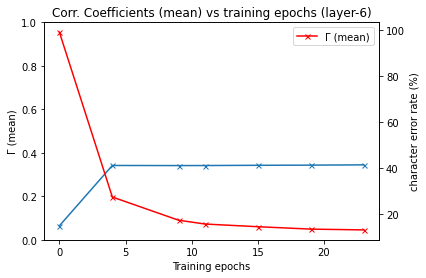

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(task_optimization_summary['epochs'], task_optimization_summary['mean'],'x-', markersize=5, label='\u0393 (mean)')
ax2.plot(task_optimization_summary['epochs'], CER,'x-', markersize=5, color='r', label='character error rate')
# plt.ylim([0, 0.5])
ax1.set_xlabel("Training epochs")
ax1.set_ylabel('\u0393 (mean)')
ax1.set_ylim(0, 1)

ax2.set_ylabel("character error rate (%)")
plt.legend(['\u0393 (mean)', 'character error rate'])
plt.title(f"Corr. Coefficients (mean) vs training epochs (layer-{layer})")
# plt.savefig(os.path.join(saved_results, 'svg_files',f'task_optimization_layer_{layer}.svg'))

# extra_axis_parameters = {
#     'width=\\figwidth',
#     'height=\\figheight',
#     'every x tick label/.append style={rotate=90}',
#     'xticklabel style={opacity=\\thisXticklabelopacity, align=center}',
# }
# tpl_save(
#     filepath=os.path.join(saved_results, 'tikz_files',f'task_optimization_layer_{layer}.tex'),
#     extra_axis_parameters=extra_axis_parameters,
#     tex_relative_path_to_data='pngs',
#     pre_tikzpicture_lines={
#         '\\providecommand{\\figwidth}{5.7in}%',
#         '\\providecommand{\\figheight}{2.0in}%',
#         '\\providecommand{\\thisXticklabelopacity}{1.0}%',
#     },
# )

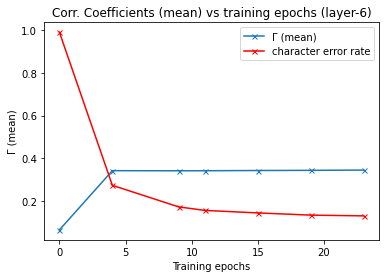

In [4]:
# fig, ax1 = plt.subplots()

plt.plot(task_optimization_summary['epochs'], task_optimization_summary['mean'],'x-', markersize=5, label='\u0393 (mean)')
plt.plot(task_optimization_summary['epochs'], CER,'x-', markersize=5, color='r', label='character error rate')
# plt.ylim([0, 0.5])
plt.xlabel("Training epochs")
plt.ylabel('\u0393 (mean)')
plt.legend()
plt.title(f"Corr. Coefficients (mean) vs training epochs (layer-{layer})")
plt.savefig(os.path.join(saved_results, 'svg_files',f'task_optimization_layer_{layer}.svg'))

# extra_axis_parameters = {
#     'width=\\figwidth',
#     'height=\\figheight',
#     'every x tick label/.append style={rotate=90}',
#     'xticklabel style={opacity=\\thisXticklabelopacity, align=center}',
# }
# tpl_save(
#     filepath=os.path.join(saved_results, 'tikz_files',f'task_optimization_layer_{layer}.tex'),
#     extra_axis_parameters=extra_axis_parameters,
#     tex_relative_path_to_data='pngs',
#     pre_tikzpicture_lines={
#         '\\providecommand{\\figwidth}{5.7in}%',
#         '\\providecommand{\\figheight}{2.0in}%',
#         '\\providecommand{\\thisXticklabelopacity}{1.0}%',
#     },
# )

In [32]:
!pwd

/home/ahmedb/projects/Wav2Letter/Auditory_Cortex/experiments/task_optimization


In [ ]:
output_dir = '../../../saved_results/svg_files/'

Text(0.5, 1.0, 'Corr. Coefficients (mean) vs accuracy (layer-6)')

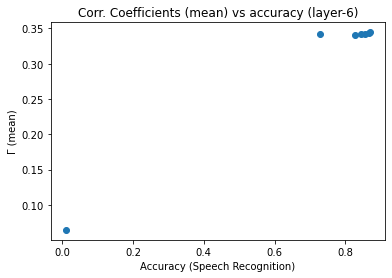

In [28]:
plt.scatter(acc, task_optimization_summary['mean'])#,'x-', markersize=5)
# plt.plot(task_optimization_summary['epochs'], ,'x-', markersize=5, color='r')
# plt.ylim([0, 0.5])
plt.xlabel("Accuracy (Speech Recognition)")
plt.ylabel('\u0393 (mean)')
plt.title(f"Corr. Coefficients (mean) vs accuracy (layer-{layer})")

In [11]:
task_optimization_summary['epochs']

[0, 4, 9, 11, 15, 19, 23]

In [7]:
task_optimization_summary['std']

[0.016051258799850854,
 0.13301249468769602,
 0.13324594348381205,
 0.13187312937098078,
 0.13263976248744117,
 0.13210839603824479,
 0.13104267672153003]

(0.0, 0.7)

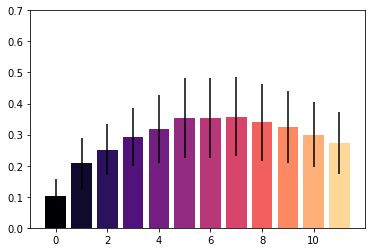

In [67]:
import matplotlib.cm as cm
cmap = cm.get_cmap('magma')
colors = cmap(np.arange(mn.shape[0])/12.0)
plt.bar(x=np.arange(mn.shape[0]), height=mn, yerr=std, color=colors)
plt.ylim([0, 0.7])